In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from itertools import product
from scipy.stats import pearsonr

In [2]:
# Import Data to Analyze
data = pd.read_csv("stock_data.csv", parse_dates = ["Date"], index_col="Date")
data = data.sort_index(ascending=True) # Set to decreasing order

In [3]:
data

,midpoint
Date,
2024-02-20,142.20
2024-02-21,143.84
2024-02-22,145.32
2024-02-23,145.29
2024-02-26,138.75
...,...
2025-02-10,188.20
2025-02-11,187.07
2025-02-12,185.43


In [4]:
# Generate return data
data["returns"] = np.log(data["midpoint"].div(data["midpoint"].shift(1)))
data

,midpoint,returns
Date,,
2024-02-20,142.20,NaN
2024-02-21,143.84,0.011467
2024-02-22,145.32,0.010237
2024-02-23,145.29,-0.000206
2024-02-26,138.75,-0.046058
...,...,...
2025-02-10,188.20,0.005648
2025-02-11,187.07,-0.006022
2025-02-12,185.43,-0.008805


In [5]:
# cleans data for duplicated values
data = data[~data.index.duplicated(keep="first")]

In [6]:
# Proprietary Derivative-based Momentum Strategy
# The basic idea is when the stock is trending up (e.g. the derivative of the stock is positive)
# and its smoothed, slower moving Simple Moving Average (SMA) is also trending up (e.g. the derivative of the SMA is positive)
# then the stock has strong upward momentum, and we want to go long
# When both derivatives are negative, we want to go short
# When the derivatives have mixed signs, the signal is not clear, and we want to be neutral

costs = 0.0005 # 5 bps assumed trading costs
Dx = 50
SMA = 65
test_data = data.copy()
test_data["SMA"] = test_data.midpoint.rolling(SMA).mean()
test_data["Stock_Dx"] = (test_data.midpoint - test_data.midpoint.shift(Dx)) / Dx
test_data["SMA_Dx"] = (test_data.SMA - test_data.SMA.shift(Dx)) / Dx

test_data["position"] = np.where(
    (np.sign(test_data.Stock_Dx) == np.sign(test_data.SMA_Dx)) & (np.sign(test_data.Stock_Dx) >= 0), 
    1,
    np.where(
        (np.sign(test_data.Stock_Dx) == np.sign(test_data.SMA_Dx)) & (np.sign(test_data.Stock_Dx) < 0), 
         -1,
         0
        )
    )

test_data["trades"] = test_data.position.diff().fillna(0).abs()

# here we take log returns (%) and subtract % costs
test_data["strategy"] = test_data.position.shift(1) * test_data.returns - (test_data.trades * costs)
test_data.dropna(inplace=True)

test_data["cum_returns"] = test_data.returns.cumsum().apply(np.exp)
test_data["cum_strategy"] = test_data.strategy.cumsum().apply(np.exp)
test_data

,midpoint,returns,SMA,Stock_Dx,SMA_Dx,position,trades,strategy,cum_returns,cum_strategy
Date,,,,,,,,,,
2024-08-02,168.40,-0.023765,178.052769,-0.2228,0.459298,0,0.0,-0.000000,0.976515,1.000000
2024-08-05,160.64,-0.047176,177.976923,-0.3472,0.446766,0,0.0,-0.000000,0.931516,1.000000
2024-08-06,160.54,-0.000623,177.855077,-0.2904,0.434723,0,0.0,-0.000000,0.930937,1.000000
2024-08-07,160.75,0.001307,177.728308,-0.3116,0.422646,0,0.0,0.000000,0.932154,1.000000
2024-08-08,163.84,0.019040,177.636154,-0.2836,0.410732,0,0.0,0.000000,0.950072,1.000000
...,...,...,...,...,...,...,...,...,...,...
2025-02-10,188.20,0.005648,188.044615,0.3754,0.424258,1,0.0,0.005648,1.091331,0.916217
2025-02-11,187.07,-0.006022,188.285538,0.3290,0.428249,1,0.0,-0.006022,1.084778,0.910716
2025-02-12,185.43,-0.008805,188.394769,0.2922,0.429068,1,0.0,-0.008805,1.075268,0.902732


In [7]:
# Optimizer for Derivative Momentum Strategy
costs = 0.0005 # 5 bps assumed trading costs
Dx_Range = range(1,100)
SMA_Range = range(25,150)
combinations = list(product(Dx_Range, SMA_Range))
results = []

for comb in combinations:
    Dx, SMA, = comb

    test_data = data.copy()
    test_data["SMA"] = test_data.midpoint.rolling(SMA).mean()
    test_data["Stock_Dx"] = (test_data.midpoint - test_data.midpoint.shift(Dx)) / Dx 
    test_data["SMA_Dx"] = (test_data.SMA - test_data.SMA.shift(Dx)) / Dx

    test_data["position"] = np.where(
        (np.sign(test_data.Stock_Dx) == np.sign(test_data.SMA_Dx)) & (np.sign(test_data.Stock_Dx) >= 0), 
        1,
        np.where(
            (np.sign(test_data.Stock_Dx) == np.sign(test_data.SMA_Dx)) & (np.sign(test_data.Stock_Dx) < 0), 
             -1,
             0
            )
        )

    test_data["trades"] = test_data.position.diff().fillna(0).abs()

    # here we take log returns (%) and subtract % costs
    test_data["strategy"] = test_data.position.shift(1) * test_data.returns - (test_data.trades * costs)
    test_data.dropna(inplace=True)

    test_data["cum_returns"] = test_data.returns.cumsum().apply(np.exp)
    test_data["cum_strategy"] = test_data.strategy.cumsum().apply(np.exp)

    returns = test_data["cum_strategy"].iloc[-1]
    
    results.append(returns)
    
    best_perf = np.max(results)
    opt = combinations[np.argmax(results)]

print(best_perf, opt)

1.3973572658089572 (8, 36)


In [8]:
# Now we can update the strategy above and receive these optimized results

In [9]:
# Proprietary Derivative-based Momentum Strategy
costs = 0.0005 # 5 bps assumed trading costs
Dx, SMA = opt
test_data = data.copy()
test_data["SMA"] = test_data.midpoint.rolling(SMA).mean()
test_data["Stock_Dx"] = (test_data.midpoint - test_data.midpoint.shift(Dx)) / Dx
test_data["SMA_Dx"] = (test_data.SMA - test_data.SMA.shift(Dx)) / Dx

test_data["position"] = np.where(
    (np.sign(test_data.Stock_Dx) == np.sign(test_data.SMA_Dx)) & (np.sign(test_data.Stock_Dx) >= 0), 
    1,
    np.where(
        (np.sign(test_data.Stock_Dx) == np.sign(test_data.SMA_Dx)) & (np.sign(test_data.Stock_Dx) < 0), 
         -1,
         0
        )
    )

test_data["trades"] = test_data.position.diff().fillna(0).abs()

# here we take log returns (%) and subtract % costs
test_data["strategy"] = test_data.position.shift(1) * test_data.returns - (test_data.trades * costs)
test_data.dropna(inplace=True)

test_data["cum_returns"] = test_data.returns.cumsum().apply(np.exp)
test_data["cum_strategy"] = test_data.strategy.cumsum().apply(np.exp)
test_data

,midpoint,returns,SMA,Stock_Dx,SMA_Dx,position,trades,strategy,cum_returns,cum_strategy
Date,,,,,,,,,,
2024-04-22,157.95,0.014219,149.347500,0.03625,0.443090,1,1.0,-0.000500,1.014321,0.999500
2024-04-23,159.92,0.012395,149.954167,-0.10875,0.454375,0,1.0,0.011895,1.026971,1.011460
2024-04-24,161.10,0.007352,150.701389,0.23875,0.494479,1,1.0,-0.000500,1.034549,1.010955
2024-04-25,157.95,-0.019747,151.372778,0.20250,0.540174,1,0.0,-0.019747,1.014321,0.991187
2024-04-26,173.69,0.094994,152.515278,2.21125,0.645799,1,0.0,0.094994,1.115399,1.089961
...,...,...,...,...,...,...,...,...,...,...
2025-02-10,188.20,0.005648,195.742222,-1.12250,0.299375,0,0.0,0.000000,1.208580,1.390540
2025-02-11,187.07,-0.006022,195.463056,-1.94500,0.166146,0,0.0,-0.000000,1.201323,1.390540
2025-02-12,185.43,-0.008805,195.331944,-2.52125,0.048681,0,0.0,-0.000000,1.190791,1.390540


In [10]:
# Calculate risk, return and sharpe ratios
# Note We need to adjust this based on the time-frame of our returns
# If we are using daily - take the returns/risk and multiply by 252 trading days
# If using  hourly price data - take the returns/risk and multiply by (252* 7)  
# If using more granual data, multiply by (252 * (number of data points in a standard trading day))
# Note: assumed 5% for the rfr here. 
buy_and_hold_return = test_data.returns.mean() * (252) # buy and hold return
buy_and_hold_risk = test_data.returns.std() * np.sqrt(252) # buy and hold risk
buy_and_hold_sharpe = (buy_and_hold_return - 0.05) / buy_and_hold_risk
strategy_return = test_data.strategy.mean() * (252) # trading strategy return
strategy_risk = test_data.strategy.std() * np.sqrt(252) # trading strategy risk
strategy_sharpe = (strategy_return - 0.05) / strategy_risk
corr, _ = pearsonr(test_data.returns, test_data.strategy)

In [11]:
# Calculate max drawdowns
stock = test_data.midpoint
stock_running_max = stock.cummax()
stock_drawdown = 1 - stock / stock_running_max
stock_max_drawdown = stock_drawdown.max()
strategy = test_data["cum_strategy"]
strategy_running_max = strategy.cummax()
strategy_drawdown = 1 - strategy / strategy_running_max
strategy_max_drawdown = strategy_drawdown.max()

In [12]:
print(f"Our Derivative Momentum Strategy returned {strategy_return:.2%} per year") 
print(f"with a sharpe ratio of {strategy_sharpe:.2f}") 
print(f"This compares to buy and hold which returned {buy_and_hold_return:.2%} per year") 
print(f"With a sharpe ratio of {buy_and_hold_sharpe:.2f}")
print(f"Our Derivative Momentum Strategy was {corr:.2f} correlated with the stock")
print("")
print(f"The maximum drawdown for the Derivative Momentum Strategy was {strategy_max_drawdown:.2%}")
print(f"This compares with the buy and hold strategy which had a maximum drawdown of {stock_max_drawdown:.2%}")

Our Derivative Momentum Strategy returned 40.93% per year
with a sharpe ratio of 1.40
This compares to buy and hold which returned 22.31% per year
With a sharpe ratio of 0.60
Our Derivative Momentum Strategy was 0.58 correlated with the stock

The maximum drawdown for the Derivative Momentum Strategy was 9.82%
This compares with the buy and hold strategy which had a maximum drawdown of 22.38%


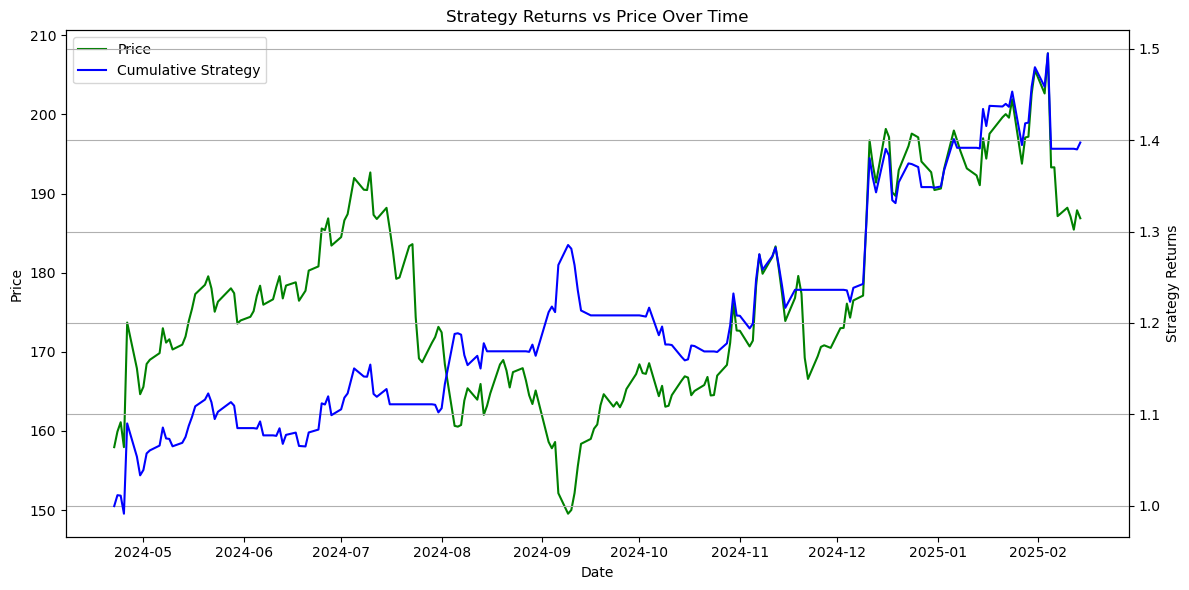

In [13]:
# Plotting Returns vs the Stock
fig, ax_left = plt.subplots(figsize=(12, 6))

# plot the stock on the LHS
ax_left.plot(test_data.index, test_data.midpoint, label='Price', linestyle='-', color = 'green')

# plot the returns on the RHS
ax_right = ax_left.twinx()
ax_right.plot(test_data.index, test_data['cum_strategy'], label='Cumulative Strategy', linestyle='-', color ="blue")

# Adding title and labels
plt.title('Strategy Returns vs Price Over Time')
ax_left.set_xlabel('Date')
ax_left.set_ylabel('Price')
ax_right.set_ylabel('Strategy Returns')


# Displaying legend
plt.grid()
lines_left, labels_left = ax_left.get_legend_handles_labels()
lines_right, labels_right = ax_right.get_legend_handles_labels()
ax_left.legend(lines_left + lines_right, labels_left + labels_right, loc='upper left')

# Displaying the plot
plt.tight_layout()
plt.show()